## Welcome to the `UNet_starter` Workshop!

In this workshop, we'll learn the Building blocks of UNet - the foundation of Encoder-Decoder architecture. The following are main components of UNet architecture:
- `Encoder` where input is passed through **2 conv layers followed by 1 max pooling layer**. The Dimension is halved during max pooling
- `Decoder` where input is passed through **2 conv layers and 1 Transposed convolution**. The Dimension is doubled during tranposed convolution

In [ ]:
# DL imports
import torch
import torch.nn as nn

## Double conv Block

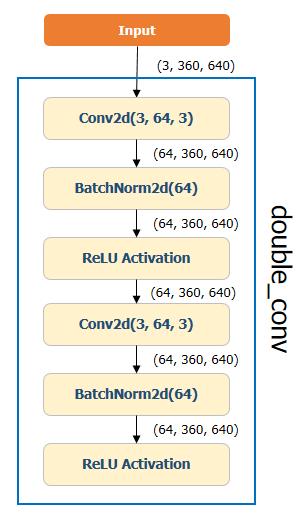

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

## UNet with 2 levels of Encoder-Decoder

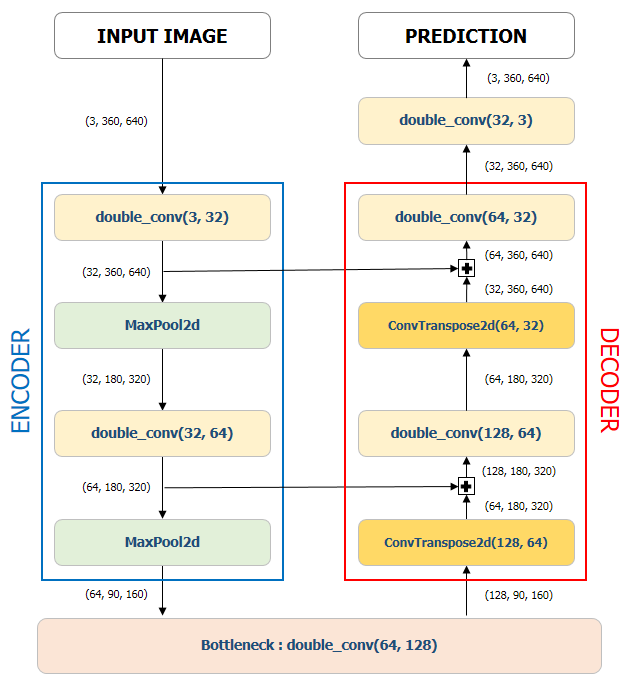

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # downsampling layers
        self.down1 = double_conv(in_channels, 32)
        self.down2 = double_conv(32, 64)

        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck layers
        self.bottleneck = double_conv(64, 128)

        # up sampling layers
        self.conv_transpose2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up2 = double_conv(128, 64) 
        self.conv_transpose1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up1 = double_conv(64, 32) 

        # final convolution to num_class channels
        self.final_conv = double_conv(32, num_classes)

    
    def forward(self, x):
        # down sampling 1
        down1_out = self.down1(x)
        pool1_out = self.pool(down1_out)

        # down sampling 2
        down2_out = self.down2(pool1_out)
        pool2_out = self.pool(down2_out)

        # bottleneck layer
        bottleneck_out = self.bottleneck(pool2_out)

        # up sampling 2
        conv_transpose2_out = self.conv_transpose2(bottleneck_out)
        skip_connection2 = torch.cat((down2_out, conv_transpose2_out), dim=1)
        up2_out = self.up2(skip_connection2)

        # up sampling 1
        conv_transpose1_out = self.conv_transpose1(up2_out)
        skip_connection1 = torch.cat((down1_out, conv_transpose1_out), dim=1)
        up1_out = self.up1(skip_connection1)

        # final output layer with num_classes as num_channels
        out = self.final_conv(up1_out)
        return out

## Test Model with sample input

In [ ]:
model = UNet(in_channels = 3, num_classes = 3)
test_input = torch.Tensor(1, 3, 360, 640)
output = model(test_input)
print(output.shape)

torch.Size([1, 3, 360, 640])


## Points to Note

1. The **Original UNet architecture used valid convolutions** - means input sizes were reduced by 1 or 2 pixels, which is not used nowadays.
2. **Original UNet architecture didn't use BatchNorm**, since the idea was proposed little later than this paper. Here, we use BatchNorm in our architecture as its proven to save from divergence by preventing exploding / vanishing gradients
3. **During skip-connection, its important to check for same size before concatenation**. If the input size is not divisible by 2 * num_layers, then we will get different shape which cannot be concatenated with encoder output directly

**References**
- [UNet arXiv paper](https://arxiv.org/abs/1505.04597)
- [Pytorch Implementation 1](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py)
- [Pytorch implementation 2](https://amaarora.github.io/2020/09/13/unet.html)
- [UNet for brain image segmentation](https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py)
- [UNet for 2d 3d segmentation](https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862)